In [2]:

# Required libraries
!pip install -q pillow pillow-heif numpy pandas scikit-image matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import torch

# Check and use Colab GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ GPU Enabled: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("⚠ GPU not available - using CPU")
    print("To enable GPU: Runtime → Change runtime type → GPU")

globals()['DEVICE'] = device


ModuleNotFoundError: No module named 'torch'

# Image Pipeline

Visualizing sample images, augmentations, and HOG features, and exporting features to `image_features.csv`.



In [12]:
# Mount Google Drive and access images from SHARED folder
import shutil
import os
# Google Drive folder ID from the link
FOLDER_ID = '1nTIBD3R7RbhgOIv4bw8EtJTBOB2rcQUA'


#Drive API to access folder by ID 
print("\n[Method 1] Using Drive API to access folder by ID...")
try:
    from google.colab import auth
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaIoBaseDownload
    import io

    # Authenticate and create Drive service
    auth.authenticate_user()
    drive_service = build('drive', 'v3')

    # Get folder metadata
    folder_metadata = drive_service.files().get(fileId=FOLDER_ID, fields='name, id').execute()
    folder_name = folder_metadata.get('name', 'Unknown')
    print(f"✓ Found folder: '{folder_name}' (ID: {FOLDER_ID})")

    # List all files in the folder
    query = f"'{FOLDER_ID}' in parents and trashed=false"
    results = drive_service.files().list(q=query, fields="files(id, name, mimeType)").execute()
    files = results.get('files', [])

    if files:
        print(f"✓ Found {len(files)} items in folder")

        # Create images directory
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
        IMAGES_DIR = os.path.join(BASE_DIR, "images")

        # Clear existing images directory to ensure only Drive folder images are used
        if os.path.exists(IMAGES_DIR):
            print(f"\n⚠ Clearing existing images directory to use only Drive folder images...")
            for existing_file in os.listdir(IMAGES_DIR):
                file_path = os.path.join(IMAGES_DIR, existing_file)
                try:
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                except Exception as e:
                    print(f"  ⚠ Could not remove {existing_file}: {str(e)}")
            print(f"  ✓ Cleared existing images")

        os.makedirs(IMAGES_DIR, exist_ok=True)

        # Download image files
        image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.heic', '.heif', '.JPG', '.JPEG', '.PNG', '.HEIC', '.HEIF')
        image_mimes = ('image/jpeg', 'image/png', 'image/bmp', 'image/heic', 'image/heif')
        copied_count = 0
        DRIVE_FOLDER_IMAGES = []  # Track downloaded filenames

        for file in files:
            file_name = file.get('name', '')
            file_id = file.get('id', '')
            file_mime = file.get('mimeType', '')

            # Check if it's an image file
            is_image = (any(file_name.lower().endswith(ext.lower()) for ext in image_extensions) or
                       file_mime.startswith('image/'))

            if is_image:
                try:
                    # Download the file
                    request = drive_service.files().get_media(fileId=file_id)
                    file_path = os.path.join(IMAGES_DIR, file_name)

                    with open(file_path, 'wb') as fh:
                        downloader = MediaIoBaseDownload(fh, request)
                        done = False
                        while not done:
                            status, done = downloader.next_chunk()

                    copied_count += 1
                    DRIVE_FOLDER_IMAGES.append(file_name)  # Track downloaded filename
                    print(f"  ✓ Downloaded: {file_name}")
                except Exception as e:
                    print(f"  ✗ Error downloading {file_name}: {str(e)}")

        print(f"\n✓ Total images downloaded: {copied_count}")
        print(f"✓ Images are now available in: {IMAGES_DIR}")
        # Store list globally for use in other cells
        globals()['DRIVE_FOLDER_IMAGES'] = DRIVE_FOLDER_IMAGES
        print(f"✓ Tracked {len(DRIVE_FOLDER_IMAGES)} image filenames from Drive folder")
        folder_path = "API_SUCCESS"

    else:
        print("✗ No files found in the folder")
        folder_path = None

except Exception as e:
    print(f"✗ Drive API method failed: {str(e)}")
    print("Trying file system search method...")
    folder_path = None

# Method 2: File system search (if API method failed)
if not folder_path or folder_path != "API_SUCCESS":
    print("\n[Method 2] Searching file system for shared folder...")

    # Check "Shared with me" directory
    shared_path = '/content/drive/MyDrive/Shared with me'

    if os.path.exists(shared_path):
        print(f"✓ Found 'Shared with me' directory")
        print("\nListing folders in 'Shared with me':")

        try:
            items = os.listdir(shared_path)
            folders_found = []
            for item in items:
                item_path = os.path.join(shared_path, item)
                if os.path.isdir(item_path):
                    folders_found.append(item)
                    print(f"  [FOLDER] {item}")

            if folders_found:
                print(f"\nFound {len(folders_found)} folder(s).")
                print("Please check if one of these is your target folder.")
                print("\nTrying to find folder by searching for image files...")

                # Search for folders containing images
                for folder_name in folders_found:
                    folder_path_candidate = os.path.join(shared_path, folder_name)
                    # Check if this folder contains images
                    image_count = 0
                    for root, dirs, files in os.walk(folder_path_candidate):
                        for f in files:
                            if any(f.lower().endswith(ext.lower()) for ext in ('.jpg', '.jpeg', '.png', '.bmp', '.heic', '.heif')):
                                image_count += 1

                    if image_count > 0:
                        print(f"\n✓ Found folder with images: '{folder_name}' ({image_count} images)")
                        folder_path = folder_path_candidate
                        break
            else:
                print("No folders found in 'Shared with me'")

        except Exception as e:
            print(f"Error listing shared folders: {str(e)}")
    else:
        print(f"✗ 'Shared with me' directory not found at: {shared_path}")
        print("The folder might need to be added to 'My Drive' first.")

    # If folder found via file system, copy images
    if folder_path and folder_path != "API_SUCCESS" and os.path.exists(folder_path):
        print(f"\n✓ Using folder at: {folder_path}")

        # Create images directory
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
        IMAGES_DIR = os.path.join(BASE_DIR, "images")

        # Clear existing images directory to ensure only Drive folder images are used
        if os.path.exists(IMAGES_DIR):
            print(f"\n⚠ Clearing existing images directory to use only Drive folder images...")
            for existing_file in os.listdir(IMAGES_DIR):
                file_path = os.path.join(IMAGES_DIR, existing_file)
                try:
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                except Exception as e:
                    print(f"  ⚠ Could not remove {existing_file}: {str(e)}")
            print(f"  ✓ Cleared existing images")

        os.makedirs(IMAGES_DIR, exist_ok=True)

        # Copy images (only from root of folder_path, not subdirectories)
        image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.heic', '.heif', '.JPG', '.JPEG', '.PNG', '.HEIC', '.HEIF')
        copied_count = 0
        DRIVE_FOLDER_IMAGES = []  # Track copied filenames

        # Only copy files directly in the folder (not subdirectories)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path) and any(file.lower().endswith(ext.lower()) for ext in image_extensions):
                dst_path = os.path.join(IMAGES_DIR, file)
                try:
                    shutil.copy2(file_path, dst_path)
                    copied_count += 1
                    DRIVE_FOLDER_IMAGES.append(file)  # Track copied filename
                    print(f"  ✓ Copied: {file}")
                except Exception as e:
                    print(f"  ✗ Error copying {file}: {str(e)}")

        print(f"\n✓ Total images copied: {copied_count}")
        print(f"✓ Images are now available in: {IMAGES_DIR}")
        # Store list globally for use in other cells
        globals()['DRIVE_FOLDER_IMAGES'] = DRIVE_FOLDER_IMAGES
        print(f"✓ Tracked {len(DRIVE_FOLDER_IMAGES)} image filenames from Drive folder")

    elif not folder_path or folder_path != "API_SUCCESS":
        print("\n" + "="*60)
        print("FOLDER NOT FOUND - MANUAL INSTRUCTIONS")
        print("="*60)
        print("\nPlease try one of these options:")
        print("\n1. ADD FOLDER TO MY DRIVE (Easiest):")
        print("   - Go to Google Drive in your browser")
        print("   - Open the shared folder")
        print("   - Right-click the folder → 'Add shortcut to Drive'")
        print("   - Then run this cell again")
        print("\n2. MANUAL PATH:")
        print("   - After mounting, find the folder path manually")
        print("   - Update the code below with the exact path")
        print("\n3. Check if folder is accessible:")
        print("   - Make sure you're signed in to the correct Google account")
        print("   - Verify you have access to the shared folder")





[Method 1] Using Drive API to access folder by ID...
✗ Drive API method failed: No module named 'google'
Trying file system search method...

[Method 2] Searching file system for shared folder...
✗ 'Shared with me' directory not found at: /content/drive/MyDrive/Shared with me
The folder might need to be added to 'My Drive' first.

FOLDER NOT FOUND - MANUAL INSTRUCTIONS

Please try one of these options:

1. ADD FOLDER TO MY DRIVE (Easiest):
   - Go to Google Drive in your browser
   - Open the shared folder
   - Right-click the folder → 'Add shortcut to Drive'
   - Then run this cell again

2. MANUAL PATH:
   - After mounting, find the folder path manually
   - Update the code below with the exact path

3. Check if folder is accessible:
   - Make sure you're signed in to the correct Google account
   - Verify you have access to the shared folder


Images directory: /images
✓ Using tracked filenames from Drive folder (12 images)
Found 12 images

Found images for 4 member(s):
  kwizera: 3 images
    - surprised: kwizera_surprised.jpg
    - neutral: kwizera_neutral.jpg
    - smiling: kwizera_smiling.jpg
  kariza: 3 images
    - surprised: kariza_surprised.jpeg
    - smiling: kariza_smiling.jpeg
    - neutral: kariza_neutral.jpeg
  Honorine: 3 images
    - surprised: Honorine_surprised.HEIC
    - smiling: Honorine_smiling.HEIC
    - neutral: Honorine_neutral.HEIC
  antony: 3 images
    - surprised: antony_surprised.jpg
    - neutral: antony_neutral.heic
    - smiling: antony_smiling.heic

DISPLAYING ORIGINAL IMAGES FOR ALL MEMBERS

--- HONORINE ---


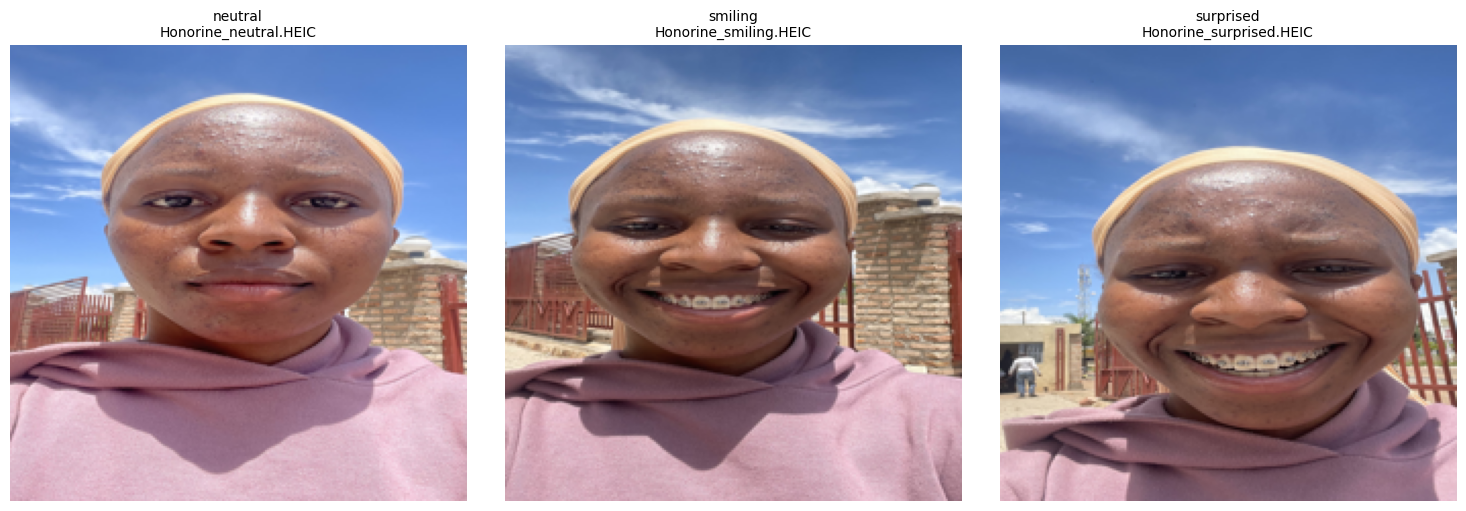


--- ANTONY ---


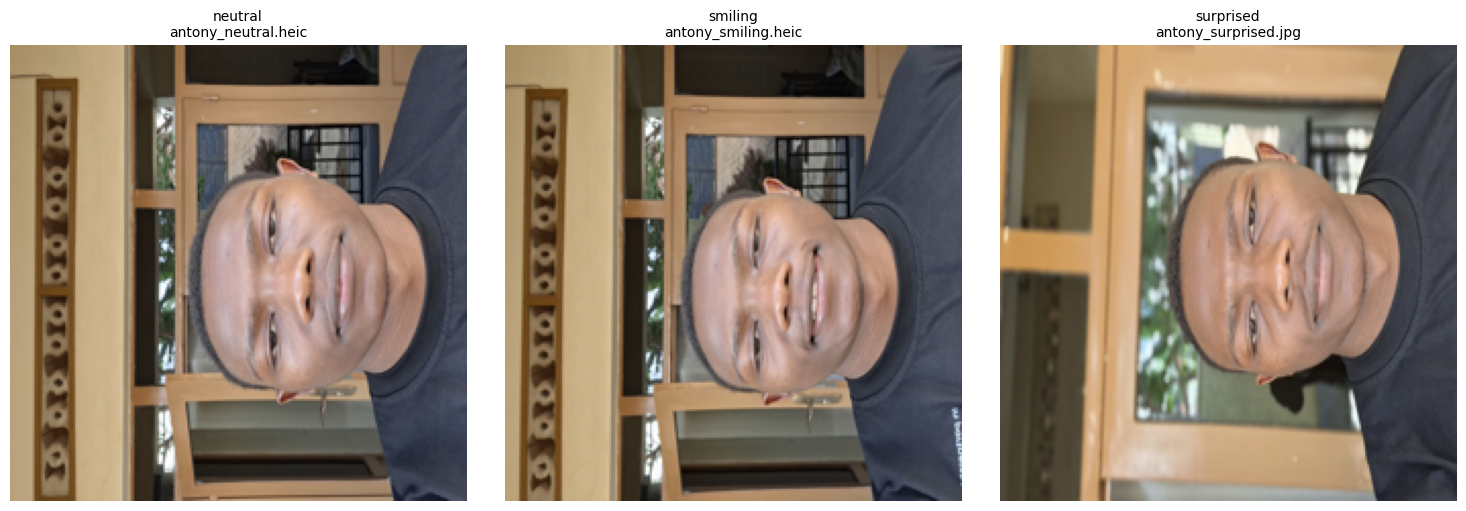


--- KARIZA ---


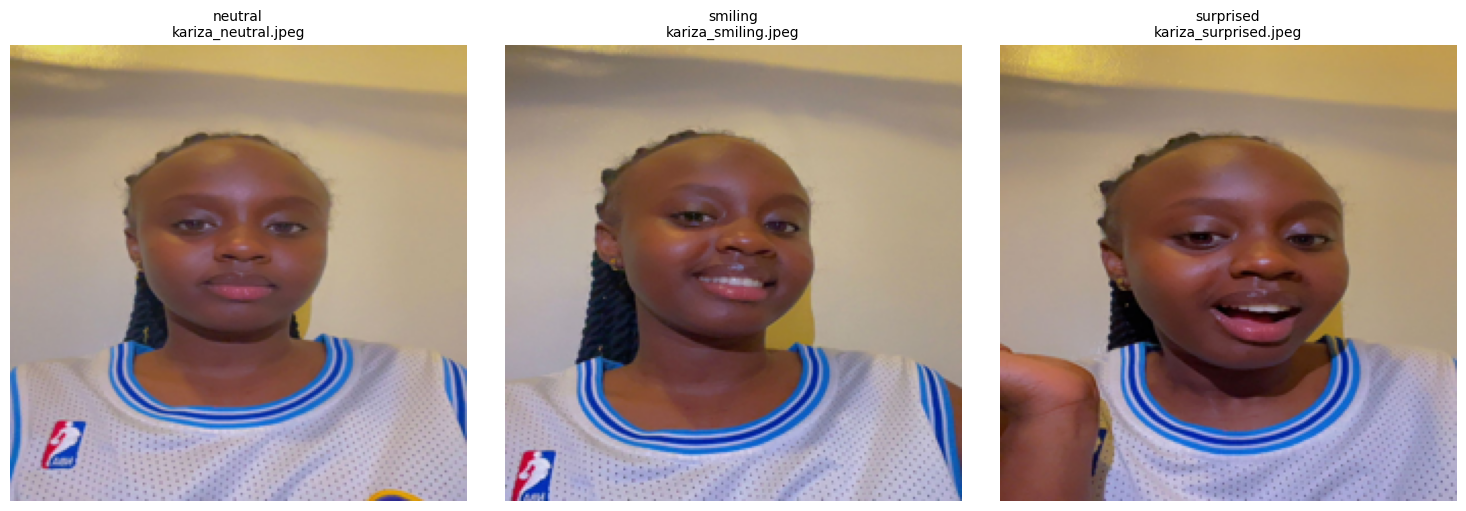


--- KWIZERA ---


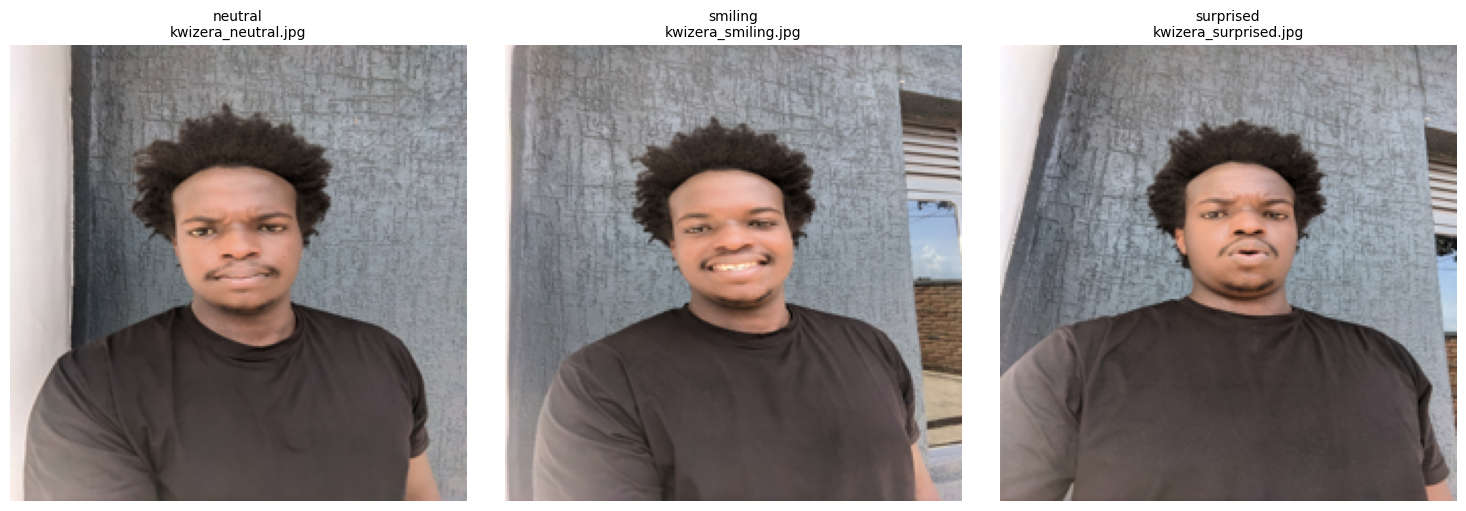


DISPLAYING AUGMENTATIONS FOR EACH MEMBER

--- Augmentations for HONORINE (using Honorine_surprised.HEIC) ---


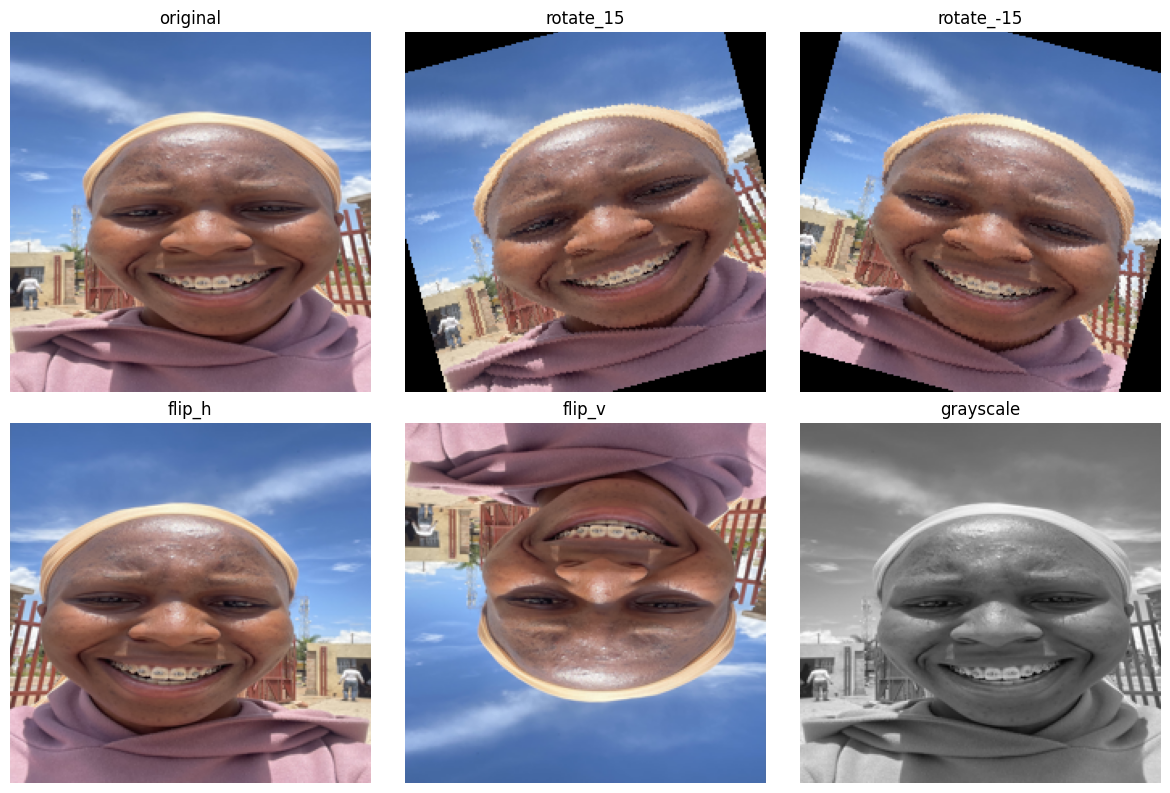


--- Augmentations for ANTONY (using antony_surprised.jpg) ---


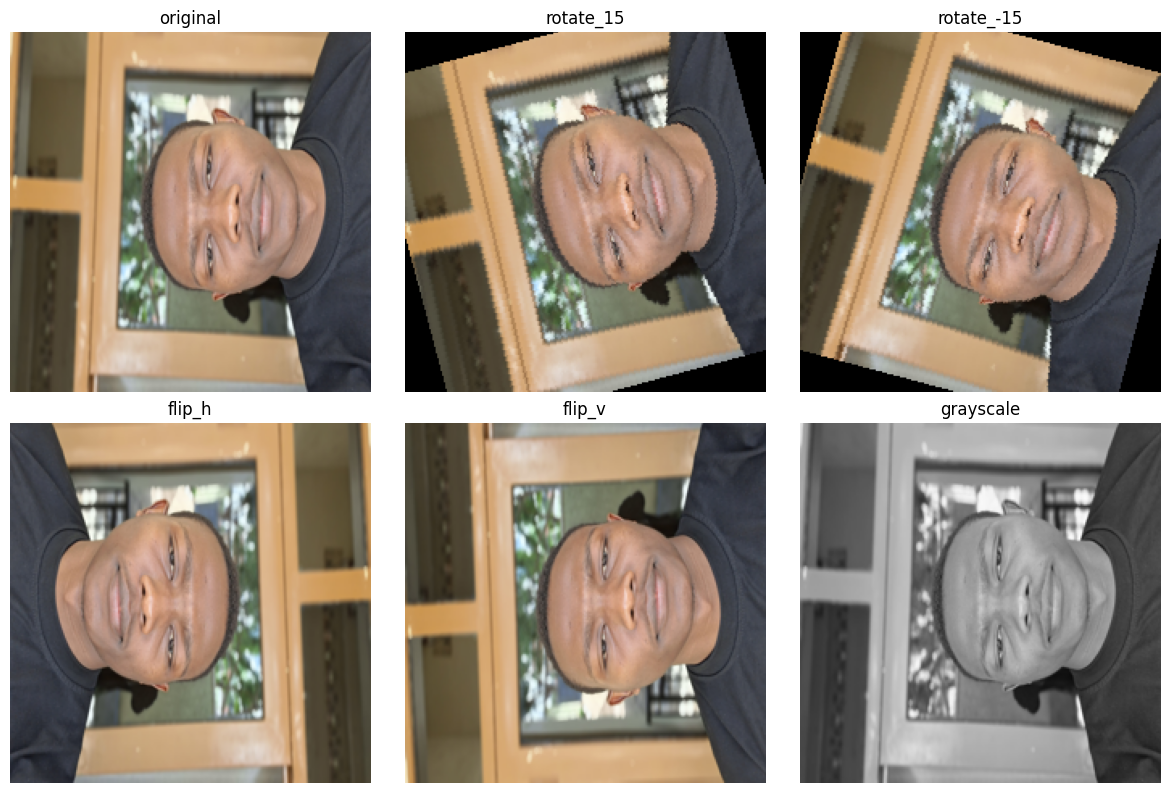


--- Augmentations for KARIZA (using kariza_surprised.jpeg) ---


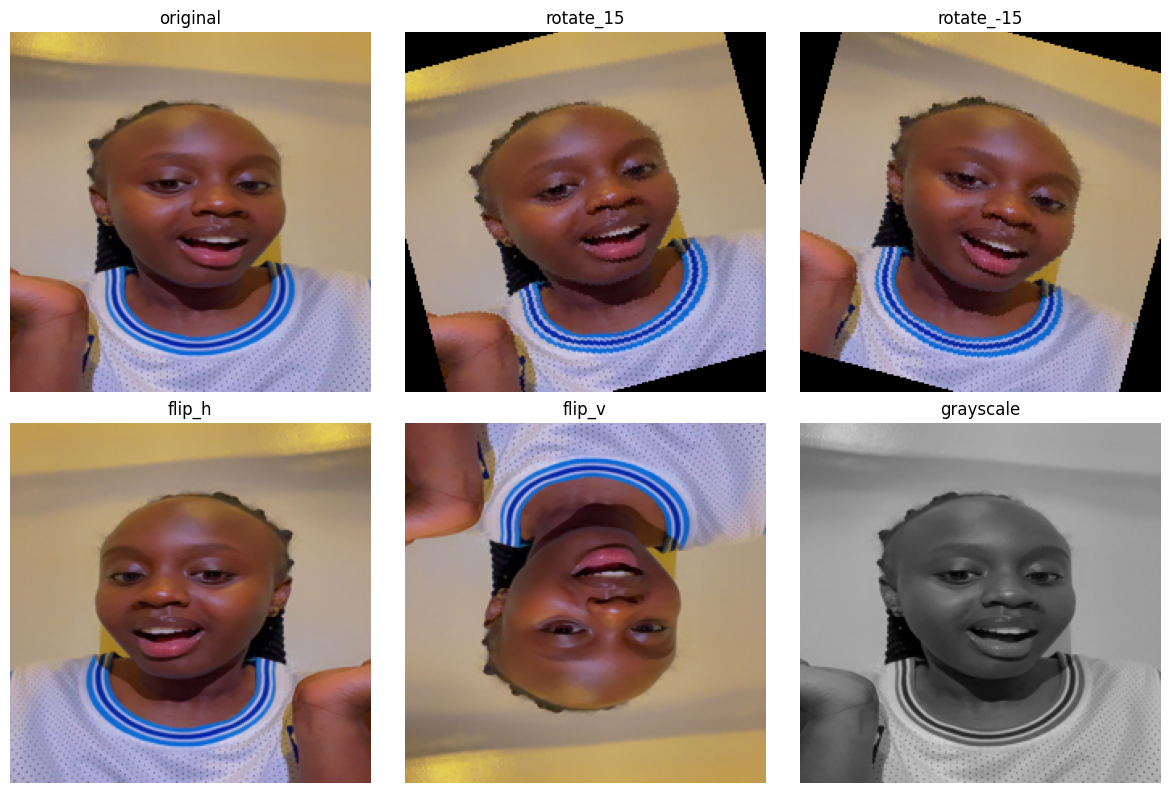


--- Augmentations for KWIZERA (using kwizera_surprised.jpg) ---


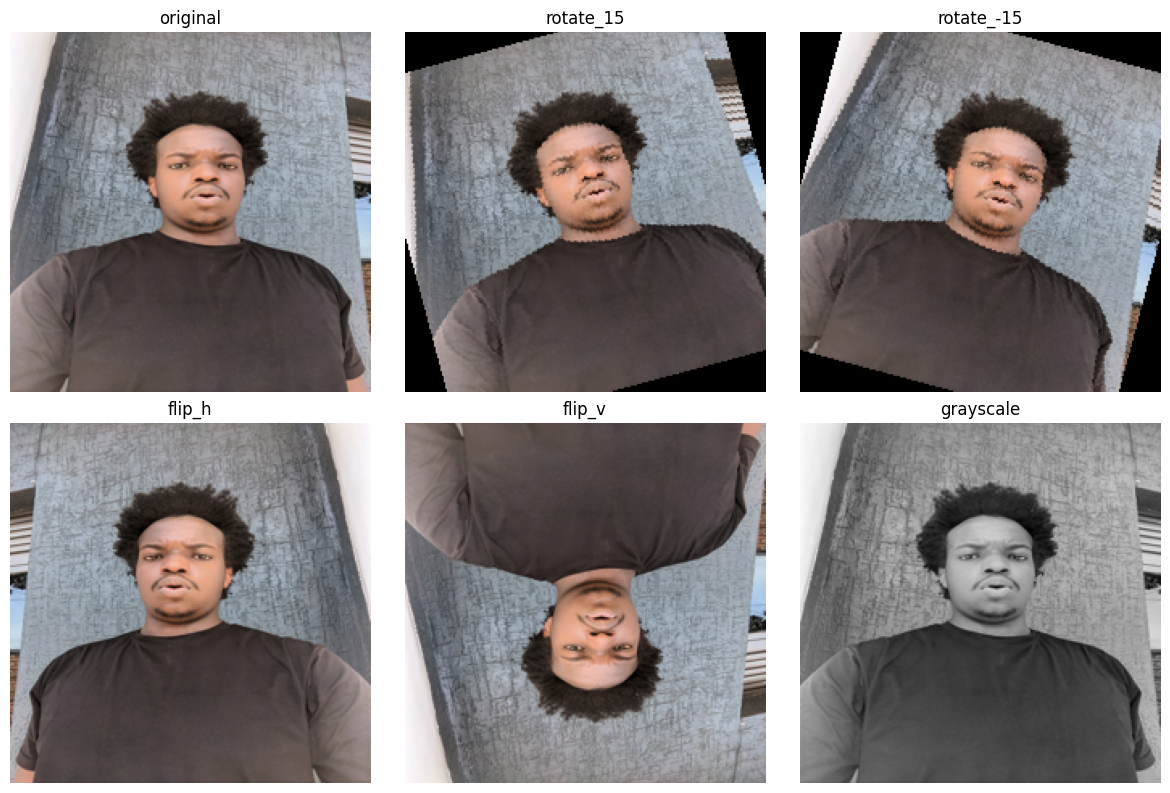

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pillow_heif
from skimage.feature import hog
from skimage.color import rgb2gray

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
IMAGES_DIR = os.path.join(BASE_DIR, "images")
print("Images directory:", IMAGES_DIR)

# Register HEIF opener for HEIC support
pillow_heif.register_heif_opener()

# Helper functions

def load_image(path, size=(224, 224)):
    img = Image.open(path).convert("RGB")
    if size:
        img = img.resize(size)
    return img


def augmentations(img):
    return {
        "original": img,
        "rotate_15": img.rotate(15),
        "rotate_-15": img.rotate(-15),
        "flip_h": ImageOps.mirror(img),
        "flip_v": ImageOps.flip(img),
        "grayscale": ImageOps.grayscale(img).convert("RGB"),
    }


def show_grid(images_dict):
    keys = list(images_dict.keys())
    n = len(keys)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(-1)
    for ax, k in zip(axes, keys):
        ax.imshow(images_dict[k])
        ax.set_title(k)
        ax.axis("off")
    for ax in axes[len(keys):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Load and display images for ALL members
# Only process images from the root of IMAGES_DIR (not subdirectories)
# This ensures we only use images from the specific Google Drive folder
all_image_paths = []

# Check if we have tracked filenames from Drive folder
DRIVE_FOLDER_IMAGES = globals().get('DRIVE_FOLDER_IMAGES', [])

if DRIVE_FOLDER_IMAGES:
    print(f"✓ Using tracked filenames from Drive folder ({len(DRIVE_FOLDER_IMAGES)} images)")
    # Only process tracked images
    for filename in DRIVE_FOLDER_IMAGES:
        file_path = os.path.join(IMAGES_DIR, filename)
        if os.path.exists(file_path) and os.path.isfile(file_path):
            all_image_paths.append(file_path)
        else:
            print(f"  ⚠ Tracked file not found: {filename}")
else:
    print("⚠ No tracked filenames found. Processing images from root of IMAGES_DIR only...")
    # Fallback: only process images in root of IMAGES_DIR (not subdirectories)
    if os.path.exists(IMAGES_DIR):
        for f in os.listdir(IMAGES_DIR):
            file_path = os.path.join(IMAGES_DIR, f)
            if os.path.isfile(file_path) and f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".heic", ".heif")):
                all_image_paths.append(file_path)

if all_image_paths:
    print(f"Found {len(all_image_paths)} images")

    # Group images by member (assuming naming: memberX_expression.jpg)
    from collections import defaultdict
    member_images = defaultdict(list)

    for img_path in all_image_paths:
        filename = os.path.basename(img_path)
        # Extract member name (everything before last underscore)
        name_parts = os.path.splitext(filename)[0].split('_')
        if len(name_parts) >= 2:
            member = '_'.join(name_parts[:-1])
            expression = name_parts[-1]
        else:
            member = "unknown"
            expression = "unknown"
        member_images[member].append((img_path, expression, filename))

    print(f"\nFound images for {len(member_images)} member(s):")
    for member, images in member_images.items():
        print(f"  {member}: {len(images)} images")
        for _, expr, fname in images:
            print(f"    - {expr}: {fname}")

    # Display original images for each member
    print("\n" + "="*60)
    print("DISPLAYING ORIGINAL IMAGES FOR ALL MEMBERS")
    print("="*60)

    for member, images in sorted(member_images.items()):
        print(f"\n--- {member.upper()} ---")
        # Sort by expression: neutral, smile, surprised
        expr_order = {'neutral': 0, 'smile': 1, 'smiling': 1, 'surprised': 2, 'surprise': 2}
        images_sorted = sorted(images, key=lambda x: expr_order.get(x[1].lower(), 99))

        fig, axes = plt.subplots(1, len(images_sorted), figsize=(5*len(images_sorted), 5))
        if len(images_sorted) == 1:
            axes = [axes]

        for ax, (img_path, expression, filename) in zip(axes, images_sorted):
            img = load_image(img_path)
            ax.imshow(img)
            ax.set_title(f"{expression}\n{filename}", fontsize=10)
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    # Display augmentations for a sample image from each member
    print("\n" + "="*60)
    print("DISPLAYING AUGMENTATIONS FOR EACH MEMBER")
    print("="*60)

    for member, images in sorted(member_images.items()):
        if images:
            # Use the first image for each member to show augmentations
            sample_path = images[0][0]
            print(f"\n--- Augmentations for {member.upper()} (using {images[0][2]}) ---")
            img = load_image(sample_path)
            show_grid(augmentations(img))

    # Store sample_paths for HOG visualization (use first image)
    sample_paths = all_image_paths
    img = load_image(sample_paths[0])  # For HOG visualization

else:
    print("No images found yet. Please add images to:", IMAGES_DIR)
    print("\nExpected naming convention:")
    print("  - member1_neutral.jpg")
    print("  - member1_smile.jpg")
    print("  - member1_surprised.jpg")
    print("  - member2_neutral.jpg")
    print("  - etc.")


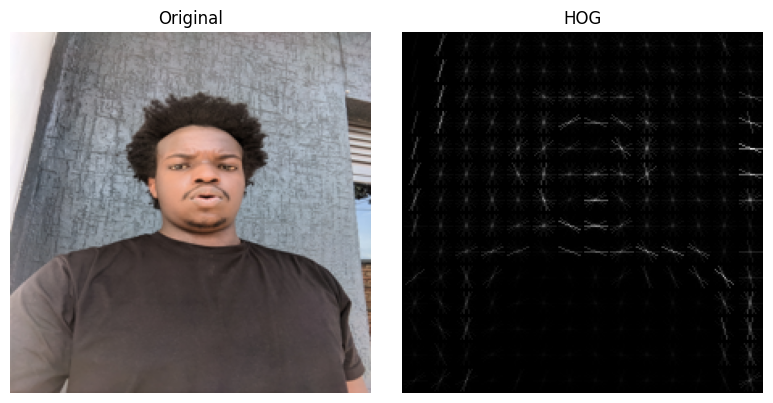

In [ ]:
# HOG visualization on the sample image
if sample_paths:
    from skimage import exposure

    gray = rgb2gray(np.array(img))
    features, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=True,
        transform_sqrt=True,
        feature_vector=True,
    )
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(hog_image_rescaled, cmap="gray")
    ax2.set_title("HOG")
    ax2.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Add images to visualize HOG.")


In [ ]:
# Setup: Get Scripts from GitHub Repository
# This cell downloads scripts from your GitHub repository: https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2

import os
import sys
import subprocess
import urllib.request

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
SCRIPTS_DIR = os.path.join(BASE_DIR, "scripts")
os.makedirs(SCRIPTS_DIR, exist_ok=True)

GITHUB_REPO = "https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2"
GITHUB_RAW = "https://raw.githubusercontent.com/Emmanuel-kwizera/ML-Pipeline-formative-2/image-pipeline"

print("="*60)
print("SETTING UP SCRIPTS FROM GITHUB")
print("="*60)
print(f"Repository: {GITHUB_REPO}")
print(f"Scripts directory: {SCRIPTS_DIR}")

# List of required scripts with their GitHub paths
required_scripts = {
    'image_processing.py': 'scripts/image_processing.py',
    'facial_recognition_model.py': 'scripts/facial_recognition_model.py',
    'facial_recognition_predict.py': 'scripts/facial_recognition_predict.py',
    'test_unauthorized.py': 'scripts/test_unauthorized.py'
}

scripts_downloaded = []
scripts_found_locally = []
scripts_failed = []

# First, check what's already available locally
print("\n[Step 1] Checking local scripts...")
for script_name in required_scripts.keys():
    local_path = os.path.join(SCRIPTS_DIR, script_name)
    if os.path.exists(local_path):
        size = os.path.getsize(local_path)
        print(f"  ✓ {script_name} - Found locally ({size} bytes)")
        scripts_found_locally.append(script_name)

# Method 1: Try cloning the repository (gets all files at once)
if len(scripts_found_locally) < len(required_scripts):
    print("\n[Step 2] Attempting to clone repository...")
    repo_dir = os.path.join(BASE_DIR, "ML-Pipeline-formative-2")

    try:
        if os.path.exists(repo_dir):
            print(f"  Repository already exists at: {repo_dir}")
            # Update it
            result = subprocess.run(
                ['git', '-C', repo_dir, 'pull'],
                capture_output=True,
                text=True,
                timeout=30
            )
            if result.returncode == 0:
                print("  ✓ Repository updated")
        else:
            # Clone repository
            result = subprocess.run(
                ['git', 'clone', GITHUB_REPO, repo_dir],
                capture_output=True,
                text=True,
                timeout=60
            )
            if result.returncode == 0:
                print(f"  ✓ Repository cloned successfully")
            else:
                print(f"  ✗ Git clone failed: {result.stderr}")
                raise Exception("Git clone failed")

        # Copy scripts from cloned repo
        repo_scripts = os.path.join(repo_dir, "scripts")
        if os.path.exists(repo_scripts):
            import shutil
            for script_name, _ in required_scripts.items():
                if script_name not in scripts_found_locally:
                    src = os.path.join(repo_scripts, script_name)
                    if os.path.exists(src):
                        dst = os.path.join(SCRIPTS_DIR, script_name)
                        shutil.copy2(src, dst)
                        print(f"  ✓ Copied {script_name}")
                        scripts_downloaded.append(script_name)
    except Exception as e:
        print(f"  ✗ Clone method failed: {str(e)}")
        print("  Trying direct download method...")

# Method 2: Download scripts directly from GitHub (works without git)
missing_scripts = [s for s in required_scripts.keys()
                   if s not in scripts_found_locally and s not in scripts_downloaded]

if missing_scripts:
    print(f"\n[Step 3] Downloading {len(missing_scripts)} script(s) from GitHub...")

    for script_name, github_path in required_scripts.items():
        if script_name in scripts_found_locally or script_name in scripts_downloaded:
            continue

        local_path = os.path.join(SCRIPTS_DIR, script_name)

        try:
            # Download from GitHub raw content
            url = f"{GITHUB_RAW}/{github_path}"
            print(f"  Downloading {script_name}...")

            urllib.request.urlretrieve(url, local_path)

            if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
                size = os.path.getsize(local_path)
                print(f"    ✓ Downloaded {script_name} ({size} bytes)")
                scripts_downloaded.append(script_name)
            else:
                print(f"    ✗ Download failed: {script_name} (file is empty)")
                scripts_failed.append(script_name)
        except urllib.error.HTTPError as e:
            if e.code == 404:
                print(f"    ✗ {script_name} not found in repository (404)")
                print(f"      → Script needs to be committed to GitHub")
            else:
                print(f"    ✗ Failed: {script_name} (HTTP {e.code})")
            scripts_failed.append(script_name)
        except Exception as e:
            print(f"    ✗ Failed to download {script_name}: {str(e)}")
            scripts_failed.append(script_name)

# Summary
print("\n" + "="*60)
print("SETUP SUMMARY")
print("="*60)
print(f"✓ Scripts found locally: {len(scripts_found_locally)}")
print(f"✓ Scripts downloaded: {len(scripts_downloaded)}")
print(f"✗ Scripts failed: {len(scripts_failed)}")

if scripts_found_locally:
    print("\nLocal scripts:")
    for script in scripts_found_locally:
        print(f"  - {script}")

if scripts_downloaded:
    print("\nDownloaded scripts:")
    for script in scripts_downloaded:
        print(f"  - {script}")

if scripts_failed:
    print("\n⚠ Missing scripts:")
    for script in scripts_failed:
        print(f"  - {script}")
    print("\nTo fix this:")
    print("1. Push scripts to GitHub repository")
    print("2. Or upload them manually to Colab")
    print(f"3. Or ensure they exist at: {SCRIPTS_DIR}")

# Final verification
print("\n" + "-"*60)
print("FINAL VERIFICATION")
print("-"*60)
all_ready = True
for script_name in required_scripts.keys():
    script_path = os.path.join(SCRIPTS_DIR, script_name)
    if os.path.exists(script_path):
        size = os.path.getsize(script_path)
        print(f"✓ {script_name} - Ready ({size} bytes)")
    else:
        print(f"✗ {script_name} - MISSING")
        all_ready = False

if all_ready:
    print("\n✓ All scripts are ready to use!")
else:
    print("\n⚠ Some scripts are missing. Please:")
    print(f"  1. Push scripts to: {GITHUB_REPO}")
    print(f"  2. Or place them in: {SCRIPTS_DIR}")



SETTING UP SCRIPTS FROM GITHUB
Repository: https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2
Scripts directory: /scripts

[Step 1] Checking local scripts...
  ✓ image_processing.py - Found locally (11089 bytes)
  ✓ facial_recognition_model.py - Found locally (14957 bytes)
  ✓ facial_recognition_predict.py - Found locally (9423 bytes)
  ✓ test_unauthorized.py - Found locally (2299 bytes)

SETUP SUMMARY
✓ Scripts found locally: 4
✓ Scripts downloaded: 0
✗ Scripts failed: 0

Local scripts:
  - image_processing.py
  - facial_recognition_model.py
  - facial_recognition_predict.py
  - test_unauthorized.py

------------------------------------------------------------
FINAL VERIFICATION
------------------------------------------------------------
✓ image_processing.py - Ready (11089 bytes)
✓ facial_recognition_model.py - Ready (14957 bytes)
✓ facial_recognition_predict.py - Ready (9423 bytes)
✓ test_unauthorized.py - Ready (2299 bytes)

✓ All scripts are ready to use!


In [ ]:
import re
import os
import pandas as pd
import numpy as np
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2gray
import pillow_heif

# Setup directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
IMAGES_DIR = os.path.join(BASE_DIR, "images")
OUTPUT_DIR = os.path.join(BASE_DIR, "data", "processed")
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "image_features.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Register HEIF opener
pillow_heif.register_heif_opener()

def load_image(path, size=(224, 224)):
    """Load and resize image"""
    img = Image.open(path).convert("RGB")
    if size:
        img = img.resize(size)
    return img

def extract_histogram_features(img):
    """Extract histogram features from RGB channels"""
    img_array = np.array(img)
    features = {}

    for i, channel_name in enumerate(['R', 'G', 'B']):
        channel = img_array[:, :, i].flatten()
        features[f'hist_{channel_name}_mean'] = float(np.mean(channel))
        features[f'hist_{channel_name}_std'] = float(np.std(channel))
        features[f'hist_{channel_name}_min'] = float(np.min(channel))
        features[f'hist_{channel_name}_max'] = float(np.max(channel))
        features[f'hist_{channel_name}_median'] = float(np.median(channel))

    gray = rgb2gray(img_array)
    features['hist_gray_mean'] = float(np.mean(gray))
    features['hist_gray_std'] = float(np.std(gray))

    return features

def extract_hog_features(img):
    """Extract HOG features"""
    gray = rgb2gray(np.array(img))
    try:
        hog_result = hog(
            gray,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            visualize=False,
            transform_sqrt=True,
            feature_vector=True,
        )
        features_vector = np.array(hog_result).flatten()
    except:
        try:
            hog_result = hog(
                gray,
                orientations=9,
                pixels_per_cell=(16, 16),
                cells_per_block=(2, 2),
                block_norm="L2-Hys",
                visualize=True,
                transform_sqrt=True,
                feature_vector=True,
            )
            if isinstance(hog_result, tuple):
                features_vector = np.array(hog_result[0]).flatten()
            else:
                features_vector = np.array(hog_result).flatten()
        except:
            return {f'hog_{i}': 0.0 for i in range(100)}

    return {f'hog_{i}': float(features_vector[i]) for i in range(len(features_vector))}

def extract_embedding_features(img):
    """Extract simple embedding-like features (patch-based mean)"""
    img_array = np.array(img)
    h, w = img_array.shape[:2]

    # Divide into patches and compute mean
    patch_size = 8
    features = {}
    patch_idx = 0

    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = img_array[y:y+patch_size, x:x+patch_size]
            if patch.size > 0:
                features[f'embedding_{patch_idx}'] = float(np.mean(patch))
                patch_idx += 1

    return features

def parse_filename(filename):
    """Parse filename to extract member name and expression
    Handles multiple formats:
    - memberX_neutral.jpg
    - memberX-neutral.jpg
    - Honorine-neutral.HEIC
    - Charlotte Kariza Suprised Pic .jpeg
    - Emmanuel Kwizera 2.jpg
    """
    name = os.path.splitext(filename)[0]

    # Define expression keywords (case insensitive)
    expression_keywords = {
        'neutral': ['neutral', 'neutre'],
        'smile': ['smile', 'smiling', 'smiles', 'happy'],
        'surprised': ['surprised', 'surprise', 'surprising', 'suprised']
    }

    # Try to find expression keyword in filename (case insensitive)
    name_lower = name.lower()
    expression = "unknown"
    found_keyword = None

    for expr, keywords in expression_keywords.items():
        for keyword in keywords:
            if keyword in name_lower:
                expression = expr
                found_keyword = keyword
                break
        if found_keyword:
            break

    # Extract member name by removing the expression keyword
    if found_keyword:
        # Remove the expression keyword and any separators around it
        # Handle both hyphen and underscore separators
        pattern = r'[\s_-]*' + re.escape(found_keyword) + r'[\s_-]*'
        member = re.sub(pattern, '', name, flags=re.IGNORECASE).strip()
        # Clean up any remaining separators at the end
        member = re.sub(r'[\s_-]+$', '', member)
    else:
        # No expression keyword found, try to split by common separators
        # Try underscore first
        if '_' in name:
            parts = name.split('_')
            if len(parts) >= 2:
                member = '_'.join(parts[:-1])
                expression = parts[-1].lower()
            else:
                member = name
        # Try hyphen
        elif '-' in name:
            parts = name.split('-')
            if len(parts) >= 2:
                member = '-'.join(parts[:-1])
                expression = parts[-1].lower()
            else:
                member = name
        # Try space (take everything except last word if it looks like a number or expression)
        elif ' ' in name:
            parts = name.split()
            # If last part is a number, it's probably not an expression
            if len(parts) >= 2 and not parts[-1].isdigit():
                member = ' '.join(parts[:-1])
                expression = parts[-1].lower()
            else:
                member = name
        else:
            member = name

    # Clean up member name
    member = member.strip()
    if not member:
        member = "unknown"

    return member, expression
print(f"Searching for images in: {IMAGES_DIR}")
if not os.path.exists(IMAGES_DIR):
    print(f"✗ ERROR: Images directory does not exist: {IMAGES_DIR}")
    print("Please make sure images are downloaded/copied to this directory first.")
else:
    image_files = []

    # Check if we have tracked filenames from Drive folder
    DRIVE_FOLDER_IMAGES = globals().get('DRIVE_FOLDER_IMAGES', [])

    if DRIVE_FOLDER_IMAGES:
        print(f"✓ Using tracked filenames from Drive folder ({len(DRIVE_FOLDER_IMAGES)} images)")
        # Only process tracked images from root of IMAGES_DIR
        for filename in DRIVE_FOLDER_IMAGES:
            file_path = os.path.join(IMAGES_DIR, filename)
            if os.path.exists(file_path) and os.path.isfile(file_path):
                image_files.append(file_path)
            else:
                print(f"  ⚠ Tracked file not found: {filename}")
    else:
        print("⚠ No tracked filenames found. Processing images from root of IMAGES_DIR only...")
        # Fallback: only process images in root of IMAGES_DIR (not subdirectories)
        for f in os.listdir(IMAGES_DIR):
            file_path = os.path.join(IMAGES_DIR, f)
            if os.path.isfile(file_path) and f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".heic", ".heif")):
                image_files.append(file_path)

    if not image_files:
        print(f"✗ ERROR: No images found in {IMAGES_DIR}")
        print("Please add images with naming: memberX_neutral.jpg, memberX_smile.jpg, memberX_surprised.jpg")
    else:
        print(f"✓ Found {len(image_files)} images")

        # Process each image
        all_data = []
        for img_path in image_files:
            try:
                filename = os.path.basename(img_path)
                member, expression = parse_filename(filename)
                print(f"Processing: {filename} (Member: {member}, Expression: {expression})")

                img = load_image(img_path)
                histogram_features = extract_histogram_features(img)
                hog_features = extract_hog_features(img)
                embedding_features = extract_embedding_features(img)

                features = {**histogram_features, **hog_features, **embedding_features}
                features['filename'] = filename
                features['member'] = member
                features['expression'] = expression
                features['image_path'] = img_path

                all_data.append(features)
                print(f"  ✓ Successfully processed: {filename}")
            except Exception as e:
                print(f"✗ Error processing {filename}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

        if all_data:
            # Create DataFrame
            df = pd.DataFrame(all_data)
            metadata_cols = ['filename', 'member', 'expression', 'image_path']
            feature_cols = [c for c in df.columns if c not in metadata_cols]
            df = df[metadata_cols + feature_cols]

            # Save to CSV
            df.to_csv(OUTPUT_FILE, index=False)

            print("\n" + "="*60)
            print("FEATURE EXTRACTION COMPLETE")
            print("="*60)
            print(f"✓ Successfully processed {len(all_data)} images")
            print(f"✓ Features saved to: {OUTPUT_FILE}")
            print(f"✓ File exists: {os.path.exists(OUTPUT_FILE)}")
            print(f"✓ File size: {os.path.getsize(OUTPUT_FILE)} bytes")
            print(f"✓ Total features per image: {len(feature_cols)}")
            print("\nFeature breakdown:")
            print(f"  - Histogram features: {len([c for c in feature_cols if c.startswith('hist_')])}")
            print(f"  - HOG features: {len([c for c in feature_cols if c.startswith('hog_')])}")
            print(f"  - Embedding features: {len([c for c in feature_cols if c.startswith('embedding_')])}")
            print(f"\nDataFrame shape: {df.shape}")
            print("\nSample data:")
            print(df[['filename', 'member', 'expression']].head())
        else:
            print("✗ ERROR: No images were successfully processed")

Searching for images in: /images
✓ Using tracked filenames from Drive folder (12 images)
✓ Found 12 images
Processing: kwizera_surprised.jpg (Member: kwizera, Expression: surprised)
  ✓ Successfully processed: kwizera_surprised.jpg
Processing: kariza_surprised.jpeg (Member: kariza, Expression: surprised)
  ✓ Successfully processed: kariza_surprised.jpeg
Processing: Honorine_surprised.HEIC (Member: Honorine, Expression: surprised)
  ✓ Successfully processed: Honorine_surprised.HEIC
Processing: antony_surprised.jpg (Member: antony, Expression: surprised)
  ✓ Successfully processed: antony_surprised.jpg
Processing: antony_neutral.heic (Member: antony, Expression: neutral)
  ✓ Successfully processed: antony_neutral.heic
Processing: antony_smiling.heic (Member: antony, Expression: smile)
  ✓ Successfully processed: antony_smiling.heic
Processing: kariza_smiling.jpeg (Member: kariza, Expression: smile)
  ✓ Successfully processed: kariza_smiling.jpeg
Processing: kwizera_neutral.jpg (Member: k

In [ ]:
# Generate features CSV by calling the script from the notebook
import subprocess, sys
import os

# Ensure BASE_DIR is defined (should be set in earlier cells)
if 'BASE_DIR' not in globals():
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
    print(f"BASE_DIR set to: {BASE_DIR}")

script_path = os.path.abspath(os.path.join(BASE_DIR, "scripts", "image_processing.py"))
print("="*60)
print("RUNNING IMAGE PROCESSING SCRIPT")
print("="*60)
print(f"Script path: {script_path}")
print(f"Script exists: {os.path.exists(script_path)}")

if not os.path.exists(script_path):
    print(f"\n✗ ERROR: Script not found at {script_path}")
    print("Please run the previous cell to download the script from Google Drive.")
else:
    print(f"\n✓ Script found. Running...")
    result = subprocess.run([sys.executable, script_path], capture_output=True, text=True)

    print("\n" + "-"*60)
    print("SCRIPT OUTPUT:")
    print("-"*60)
    print(result.stdout)

    if result.stderr:
        print("\n" + "-"*60)
        print("WARNINGS/ERRORS:")
        print("-"*60)
        print(result.stderr)

    if result.returncode != 0:
        print(f"\n✗ Script exited with error code: {result.returncode}")
    else:
        print(f"\n✓ Script completed successfully!")

    # Check if CSV was created
    output_file = os.path.join(BASE_DIR, "data", "processed", "image_features.csv")
    if os.path.exists(output_file):
        print(f"\n✓ CSV file created at: {output_file}")
        print(f"  File size: {os.path.getsize(output_file)} bytes")
    else:
        print(f"\n⚠ CSV file not found at: {output_file}")
        print("  Checking alternative locations...")

        # Try to find the CSV file
        possible_locations = [
            os.path.join(BASE_DIR, "data", "processed", "image_features.csv"),
            os.path.join(os.getcwd(), "data", "processed", "image_features.csv"),
            "data/processed/image_features.csv",
            "image_features.csv",
        ]

        found = False
        for loc in possible_locations:
            if os.path.exists(loc):
                print(f"  ✓ Found CSV at: {loc}")
                found = True
                break

        if not found:
            print("  ✗ CSV not found in any expected location")
            print("  Please check the script output above for errors")


RUNNING IMAGE PROCESSING SCRIPT
Script path: /scripts/image_processing.py
Script exists: True

✓ Script found. Running...

------------------------------------------------------------
SCRIPT OUTPUT:
------------------------------------------------------------
Processing images from: /images
Output file: /data/processed/image_features.csv
Found 12 images
Processing: antony_neutral.heic (Member: antony, Expression: neutral)
Processing: kwizera_neutral.jpg (Member: kwizera, Expression: neutral)
Processing: antony_surprised.jpg (Member: antony, Expression: surprised)
Processing: kariza_surprised.jpeg (Member: kariza, Expression: surprised)
Processing: Honorine_smiling.HEIC (Member: Honorine, Expression: smile)
Processing: kwizera_surprised.jpg (Member: kwizera, Expression: surprised)
Processing: antony_smiling.heic (Member: antony, Expression: smile)
Processing: kariza_neutral.jpeg (Member: kariza, Expression: neutral)
Processing: kwizera_smiling.jpg (Member: kwizera, Expression: smile)
Pr

In [ ]:
# Verify and display the generated CSV file
import pandas as pd
import os

# Ensure BASE_DIR is defined
if 'BASE_DIR' not in globals():
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
    print(f"BASE_DIR set to: {BASE_DIR}")

# Try to find the CSV file in multiple possible locations
possible_paths = [
    os.path.join(BASE_DIR, "data", "processed", "image_features.csv"),
    os.path.join(os.getcwd(), "data", "processed", "image_features.csv"),
    os.path.join(os.getcwd(), "..", "data", "processed", "image_features.csv"),
    "data/processed/image_features.csv",
    "../data/processed/image_features.csv",
    "image_features.csv",
]

OUTPUT_FILE = None
for path in possible_paths:
    if os.path.exists(path):
        OUTPUT_FILE = os.path.abspath(path)
        print(f"✓ Found CSV file at: {OUTPUT_FILE}")
        break

if OUTPUT_FILE and os.path.exists(OUTPUT_FILE):
    df = pd.read_csv(OUTPUT_FILE)

    print("="*60)
    print("IMAGE FEATURES CSV VERIFICATION")
    print("="*60)
    print(f"\n✓ CSV file successfully created: {OUTPUT_FILE}")
    print(f"✓ Total images processed: {len(df)}")
    print(f"✓ Total features per image: {len(df.columns) - 4}")  # Excluding metadata columns

    print("\n" + "-"*60)
    print("FEATURE BREAKDOWN:")
    print("-"*60)

    # Count feature types
    hist_features = [c for c in df.columns if c.startswith('hist_')]
    hog_features = [c for c in df.columns if c.startswith('hog_')]
    embedding_features = [c for c in df.columns if c.startswith('embedding_')]

    print(f"  • Histogram features: {len(hist_features)}")
    print(f"  • HOG features: {len(hog_features)}")
    print(f"  • Embedding features: {len(embedding_features)}")

    print("\n" + "-"*60)
    print("MEMBERS AND EXPRESSIONS:")
    print("-"*60)
    member_summary = df.groupby('member')['expression'].value_counts().unstack(fill_value=0)
    print(member_summary)

    print("\n" + "-"*60)
    print("SAMPLE DATA (First 3 rows):")
    print("-"*60)
    display_cols = ['filename', 'member', 'expression'] + hist_features[:3] + hog_features[:3] + embedding_features[:3]
    print(df[display_cols].head(3).to_string())

    print("\n" + "-"*60)
    print("CSV FILE SUMMARY:")
    print("-"*60)
    print(f"  • File location: {OUTPUT_FILE}")
    print(f"  • File size: {os.path.getsize(OUTPUT_FILE) / 1024:.2f} KB")
    print(f"  • Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"  • Missing values: {df.isnull().sum().sum()}")

    print("\n✓ All requirements for Task 2 appear to be met!")
    print("  ✓ Images loaded and displayed for all members")
    print("  ✓ Augmentations applied (rotation, flipping, grayscale)")
    print("  ✓ Features extracted (histograms, HOG, embeddings)")
    print("  ✓ Features saved to image_features.csv")

else:
    print("="*60)
    print("ERROR: CSV FILE NOT FOUND")
    print("="*60)
    print(f"\n✗ Could not find image_features.csv in any expected location.")
    print("\nSearched in:")
    for path in possible_paths:
        abs_path = os.path.abspath(path) if not os.path.isabs(path) else path
        exists = "✓" if os.path.exists(path) else "✗"
        print(f"  {exists} {abs_path}")

    print("\nTroubleshooting steps:")
    print("1. Make sure you ran the previous cell (Cell 7) to execute the script")
    print("2. Check the script output above for any errors")
    print("3. Verify that images exist in the images/ directory")
    print("4. Check if the script completed successfully")
    print("\nTo regenerate the CSV, run Cell 7 again.")

    # Try to check if images directory exists
    if 'IMAGES_DIR' in globals() or 'BASE_DIR' in globals():
        images_dir = globals().get('IMAGES_DIR', os.path.join(BASE_DIR, "images"))
        if os.path.exists(images_dir):
            image_files = [f for f in os.listdir(images_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.heic', '.heif'))]
            print(f"\nImages directory status:")
            print(f"  Location: {images_dir}")
            print(f"  Images found: {len(image_files)}")
            if len(image_files) == 0:
                print("  ⚠ No images found! Please add images to the images/ directory first.")
            else:
                print(f"  Sample files: {image_files[:3]}")
        else:
            print(f"\n⚠ Images directory not found: {images_dir}")


✓ Found CSV file at: /data/processed/image_features.csv
IMAGE FEATURES CSV VERIFICATION

✓ CSV file successfully created: /data/processed/image_features.csv
✓ Total images processed: 12
✓ Total features per image: 8459

------------------------------------------------------------
FEATURE BREAKDOWN:
------------------------------------------------------------
  • Histogram features: 17
  • HOG features: 6088
  • Embedding features: 2354

------------------------------------------------------------
MEMBERS AND EXPRESSIONS:
------------------------------------------------------------
expression  neutral  smile  surprised
member                               
Honorine          1      1          1
antony            1      1          1
kariza            1      1          1
kwizera           1      1          1

------------------------------------------------------------
SAMPLE DATA (First 3 rows):
------------------------------------------------------------
               filename   member 

# Task 4: Facial Recognition Model

This cell trains a facial recognition model to identify members from image features.
The model uses the features extracted in the previous cells.


In [14]:
# Train Facial Recognition Model
import os
import sys
import subprocess
import urllib.request
import importlib.util

# Ensure BASE_DIR is defined
if 'BASE_DIR' not in globals():
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Path to training script
SCRIPTS_DIR = os.path.join(BASE_DIR, "scripts")
script_path = os.path.join(SCRIPTS_DIR, "facial_recognition_model.py")

# CSV file location (where image_features.csv is saved)
CSV_FILE = os.path.join(BASE_DIR, "data", "processed", "image_features.csv")

GITHUB_RAW = "https://raw.githubusercontent.com/Emmanuel-kwizera/ML-Pipeline-formative-2/image-pipeline"

print("="*60)
print("TRAINING FACIAL RECOGNITION MODEL")
print("="*60)
print(f"Script: {script_path}")
print(f"CSV file location: {CSV_FILE}")

# Check if CSV exists
if os.path.exists(CSV_FILE):
    size = os.path.getsize(CSV_FILE)
    print(f"✓ CSV file found ({size / 1024:.2f} KB)")
else:
    print(f"⚠ CSV file not found at: {CSV_FILE}")
    print("  Please run the feature extraction cell (Cell 7) first!")

# Always download script from GitHub to ensure latest version
print(f"\n📥 Downloading script from GitHub...")
os.makedirs(SCRIPTS_DIR, exist_ok=True)

# Clear any cached .pyc files to ensure fresh script execution
import glob
pyc_files = glob.glob(os.path.join(SCRIPTS_DIR, "*.pyc"))
for pyc_file in pyc_files:
    try:
        os.remove(pyc_file)
    except:
        pass

# Download from GitHub
try:
    url = f"{GITHUB_RAW}/scripts/facial_recognition_model.py"
    print(f"  Downloading from: {url}")
    urllib.request.urlretrieve(url, script_path)

    if os.path.exists(script_path) and os.path.getsize(script_path) > 0:
        size = os.path.getsize(script_path)
        print(f"  ✓ Downloaded script from GitHub ({size} bytes)")
    else:
        print(f"  ✗ Download failed - file is empty")
except urllib.error.HTTPError as e:
    if e.code == 404:
        print(f"  ✗ Script not found in GitHub repository (404)")
        print(f"  Please ensure the script is committed to: https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2")
        print(f"  Branch: image-pipeline")
        print(f"  Path: scripts/facial_recognition_model.py")
    else:
        print(f"  ✗ Download failed: HTTP {e.code}")
except Exception as e:
    print(f"  ✗ Download failed: {str(e)}")
    if os.path.exists(script_path):
        print(f"  ⚠ Using existing local script as fallback")

# Now check again and run
if not os.path.exists(script_path):
    print(f"\n✗ ERROR: Script not found at {script_path}")
    print("Please ensure the script exists or is available in the GitHub repository.")
else:
    print(f"\n✓ Script found. Running...")
    result = subprocess.run([sys.executable, script_path], capture_output=True, text=True)

    print("\n" + "-"*60)
    print("TRAINING OUTPUT:")
    print("-"*60)
    print(result.stdout)

    if result.stderr:
        print("\n" + "-"*60)
        print("WARNINGS/ERRORS:")
        print("-"*60)
        print(result.stderr)

    if result.returncode == 0:
        print("\n✓ Model training completed successfully!")
        model_path = os.path.join(BASE_DIR, 'models', 'facial_recognition_model.pkl')
        print(f"✓ Model saved to: {model_path}")
        if os.path.exists(model_path):
            size = os.path.getsize(model_path)
            print(f"  Model size: {size / 1024:.2f} KB")
    else:
        print(f"\n✗ Training failed with exit code: {result.returncode}")
        print("\nTroubleshooting:")
        print("1. Check that image_features.csv exists")
        print("2. Verify scripts are in the repository")
        print("3. Check the error messages above")



TRAINING FACIAL RECOGNITION MODEL
Script: /scripts/facial_recognition_model.py
CSV file location: /data/processed/image_features.csv
✓ CSV file found (1778.23 KB)

📥 Downloading script from GitHub...
  ✓ Downloaded script from GitHub (14957 bytes)

✓ Script found. Running...

------------------------------------------------------------
TRAINING OUTPUT:
------------------------------------------------------------
FACIAL RECOGNITION MODEL TRAINING
LOADING IMAGE FEATURES
✓ Loaded 12 images
✓ Features shape: (12, 8463)
✓ Using 8459 features per image
✓ Members in dataset: 4
  Members: ['Honorine', 'antony', 'kariza', 'kwizera']
✓ Label encoding: {'Honorine': np.int64(0), 'antony': np.int64(1), 'kariza': np.int64(2), 'kwizera': np.int64(3)}

TRAINING FACIAL RECOGNITION MODEL (RANDOM_FOREST)
Dataset info: 12 samples, 4 classes
⚠ Small dataset detected (12 samples, 4 classes)
  Estimated test samples (2) < classes (4) OR insufficient data
  Using all data for training and evaluation (no test 

In [15]:
# Locate Features and Model Files for GitHub
# This cell shows you where the files are saved and helps you prepare them for GitHub

import os
import shutil

print("="*60)
print("LOCATING FILES FOR GITHUB")
print("="*60)

# Search in multiple common locations
current_dir = os.getcwd()
print(f"\nCurrent working directory: {current_dir}")

# Common base directories to search
search_dirs = [
    current_dir,  # Current directory
    os.path.join(current_dir, ".."),  # Parent directory
    "/content",  # Standard Colab directory
    "/content/..",  # Parent of content
    os.path.abspath(os.path.join(current_dir, "..")),  # Absolute parent
]

# Remove duplicates and non-existent paths
search_dirs = [os.path.abspath(d) for d in search_dirs if os.path.exists(d)]
search_dirs = list(dict.fromkeys(search_dirs))  # Remove duplicates while preserving order

print(f"\nSearching in {len(search_dirs)} location(s):")
for d in search_dirs:
    print(f"  - {d}")

# Search for features CSV
features_file = None
possible_feature_paths = []
for base_dir in search_dirs:
    path = os.path.join(base_dir, "data", "processed", "image_features.csv")
    possible_feature_paths.append(path)
    if os.path.exists(path):
        features_file = os.path.abspath(path)
        break

# Also check if BASE_DIR is set and use it
if 'BASE_DIR' in globals() and BASE_DIR:
    base_path = os.path.join(BASE_DIR, "data", "processed", "image_features.csv")
    if os.path.exists(base_path):
        features_file = os.path.abspath(base_path)

print(f"\n📊 Features CSV:")
if features_file and os.path.exists(features_file):
    size = os.path.getsize(features_file)
    print(f"   ✓ Found ({size / 1024:.2f} KB)")
    print(f"   Path: {features_file}")
else:
    print(f"   ✗ Not found in any of the searched locations")
    print(f"   Searched paths:")
    for path in possible_feature_paths[:5]:  # Show first 5
        print(f"     - {path}")

# Search for model files
model_dir = None
possible_model_paths = []
for base_dir in search_dirs:
    path = os.path.join(base_dir, "models")
    possible_model_paths.append(path)
    if os.path.exists(path):
        model_dir = os.path.abspath(path)
        break

# Also check if BASE_DIR is set and use it
if 'BASE_DIR' in globals() and BASE_DIR:
    base_path = os.path.join(BASE_DIR, "models")
    if os.path.exists(base_path):
        model_dir = os.path.abspath(base_path)

print(f"\n🤖 Model Files:")
if model_dir and os.path.exists(model_dir):
    print(f"   Directory: {model_dir}")
    model_files = {
        'Model': 'facial_recognition_model.pkl',
        'Scaler': 'facial_recognition_scaler.pkl',
        'Metadata': 'facial_recognition_metadata.pkl'
    }

    found_any = False
    for file_type, filename in model_files.items():
        file_path = os.path.join(model_dir, filename)
        if os.path.exists(file_path):
            size = os.path.getsize(file_path)
            print(f"   ✓ {file_type}: {filename} ({size / 1024:.2f} KB)")
            print(f"     Path: {os.path.abspath(file_path)}")
            found_any = True
        else:
            print(f"   ✗ {file_type}: {filename} (not found)")

    if not found_any:
        print(f"   ⚠ Directory exists but no model files found")
else:
    print(f"   ✗ Models directory not found in any of the searched locations")
    print(f"   Searched paths:")
    for path in possible_model_paths[:5]:  # Show first 5
        print(f"     - {path}")

# Summary for GitHub
print("\n" + "="*60)
print("FILES TO PUSH TO GITHUB")
print("="*60)

if features_file and os.path.exists(features_file):
    print("\n1. Features CSV:")
    print(f"   {features_file}")
    # Determine relative path for GitHub
    if "/content/" in features_file:
        rel_path = features_file.split("/content/")[-1] if "/content/" in features_file else features_file
        print(f"   GitHub path: {rel_path}")
else:
    print("\n1. Features CSV: ⚠ Not found - run feature extraction cell first")

if model_dir and os.path.exists(model_dir):
    print("\n2. Model Files (in models/ directory):")
    model_files_list = [f for f in sorted(os.listdir(model_dir)) if f.endswith('.pkl')]
    if model_files_list:
        for file in model_files_list:
            print(f"   models/{file}")
        # Determine relative path for GitHub
        if "/content/" in model_dir:
            rel_path = model_dir.split("/content/")[-1] if "/content/" in model_dir else model_dir
            print(f"   GitHub directory: {rel_path}")
    else:
        print("   ⚠ No .pkl files found in models directory")
else:
    print("\n2. Model Files: ⚠ Not found - run training cell first")

print("\n3. To push to GitHub, you can:")
print("   Option A: Download files from Colab (right-click → Download)")
print("   Option B: Use git commands in Colab terminal:")
if features_file and model_dir:
    # Extract base directory from found paths
    base_from_features = os.path.dirname(os.path.dirname(os.path.dirname(features_file)))
    base_from_models = os.path.dirname(model_dir)

    # Use the common base if both exist
    common_base = base_from_features if base_from_features == base_from_models else current_dir
    print(f"     !cd {common_base}")
    print(f"     !git clone https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2.git")
    print(f"     !cd ML-Pipeline-formative-2 && git checkout image-pipeline")
    print(f"     !cp -r ../data ./")
    print(f"     !cp -r ../models ./")
    print(f"     !git add data/ models/")
    print(f"     !git commit -m 'Add features and models'")
    print(f"     !git push origin image-pipeline")
else:
    print("     !cd /content")
    print("     !git clone https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2.git")
    print("     !cd ML-Pipeline-formative-2 && git checkout image-pipeline")
    print("     !cp -r ../data ./")
    print("     !cp -r ../models ./")
    print("     !git add data/ models/")
    print("     !git commit -m 'Add features and models'")
    print("     !git push origin image-pipeline")

print("\n4. Or copy to Google Drive first:")
drive_backup = "/content/drive/MyDrive/ML-Pipeline-backup"
if os.path.exists("/content/drive"):
    os.makedirs(drive_backup, exist_ok=True)
    copied_any = False
    if features_file and os.path.exists(features_file):
        shutil.copy2(features_file, os.path.join(drive_backup, "image_features.csv"))
        print(f"   ✓ Copied features CSV to: {drive_backup}/image_features.csv")
        copied_any = True
    if model_dir and os.path.exists(model_dir):
        backup_models = os.path.join(drive_backup, "models")
        if os.path.exists(backup_models):
            shutil.rmtree(backup_models)
        shutil.copytree(model_dir, backup_models)
        print(f"   ✓ Copied models to: {drive_backup}/models/")
        copied_any = True
    if copied_any:
        print(f"\n   Files backed up to Google Drive: {drive_backup}")
    else:
        print("   ⚠ No files to copy (files not found)")
else:
    print("   Google Drive not mounted")


LOCATING FILES FOR GITHUB

Current working directory: /content

Searching in 2 location(s):
  - /content
  - /

📊 Features CSV:
   ✓ Found (1778.23 KB)
   Path: /data/processed/image_features.csv

🤖 Model Files:
   Directory: /models
   ✓ Model: facial_recognition_model.pkl (201.18 KB)
     Path: /models/facial_recognition_model.pkl
   ✓ Scaler: facial_recognition_scaler.pkl (198.84 KB)
     Path: /models/facial_recognition_scaler.pkl
   ✓ Metadata: facial_recognition_metadata.pkl (103.38 KB)
     Path: /models/facial_recognition_metadata.pkl

FILES TO PUSH TO GITHUB

1. Features CSV:
   /data/processed/image_features.csv

2. Model Files (in models/ directory):
   models/facial_recognition_metadata.pkl
   models/facial_recognition_model.pkl
   models/facial_recognition_scaler.pkl

3. To push to GitHub, you can:
   Option A: Download files from Colab (right-click → Download)
   Option B: Use git commands in Colab terminal:
     !cd /
     !git clone https://github.com/Emmanuel-kwizera/M

In [5]:
# Test Unauthorized Face Detection
# This cell simulates an unauthorized attempt by testing with an image of someone NOT in the training dataset

import os
import sys
import subprocess
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib.request
import importlib.util

# Ensure BASE_DIR is defined
if 'BASE_DIR' not in globals():
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add scripts directory to path
SCRIPTS_DIR = os.path.join(BASE_DIR, "scripts")
os.makedirs(SCRIPTS_DIR, exist_ok=True)
sys.path.insert(0, SCRIPTS_DIR)

# Install required dependencies first
print("="*60)
print("INSTALLING REQUIRED DEPENDENCIES")
print("="*60)

required_packages = {
    'pillow-heif': 'pillow_heif',
    'scikit-image': 'skimage',
    'joblib': 'joblib',
    'pandas': 'pandas',
    'numpy': 'numpy',
    'Pillow': 'PIL'
}

missing_packages = []
for package_name, import_name in required_packages.items():
    try:
        __import__(import_name)
        print(f"✓ {package_name} already installed")
    except ImportError:
        missing_packages.append(package_name)
        print(f"✗ {package_name} not found - will install")

if missing_packages:
    print(f"\nInstalling missing packages: {', '.join(missing_packages)}")
    for package in missing_packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
            print(f"✓ Installed {package}")
        except Exception as e:
            print(f"✗ Failed to install {package}: {e}")

# Download facial_recognition_predict.py from GitHub
GITHUB_RAW = "https://raw.githubusercontent.com/Emmanuel-kwizera/ML-Pipeline-formative-2/image-pipeline"
script_path = os.path.join(SCRIPTS_DIR, "facial_recognition_predict.py")

print("\n" + "="*60)
print("DOWNLOADING PREDICTION SCRIPT FROM GITHUB")
print("="*60)

try:
    url = f"{GITHUB_RAW}/scripts/facial_recognition_predict.py"
    print(f"Downloading from: {url}")
    urllib.request.urlretrieve(url, script_path)

    if os.path.exists(script_path) and os.path.getsize(script_path) > 0:
        size = os.path.getsize(script_path)
        print(f"✓ Downloaded script from GitHub ({size} bytes)")
    else:
        print(f"✗ Download failed - file is empty")
except urllib.error.HTTPError as e:
    if e.code == 404:
        print(f"✗ Script not found in GitHub repository (404)")
        print(f"  Please ensure the script is committed to: https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2")
        print(f"  Branch: image-pipeline")
        print(f"  Path: scripts/facial_recognition_predict.py")
    else:
        print(f"✗ Download failed: HTTP {e.code}")
except Exception as e:
    print(f"✗ Download failed: {str(e)}")
    if os.path.exists(script_path):
        print(f"⚠ Using existing local script as fallback")

# Import prediction functions
# Clear any cached modules first
import importlib
if 'facial_recognition_predict' in sys.modules:
    del sys.modules['facial_recognition_predict']

# Ensure scripts directory is in path
if SCRIPTS_DIR not in sys.path:
    sys.path.insert(0, SCRIPTS_DIR)

# Verify script exists
if not os.path.exists(script_path):
    raise FileNotFoundError(f"Script not found at {script_path}")

# Import using importlib to ensure fresh import
try:
    spec = importlib.util.spec_from_file_location("facial_recognition_predict", script_path)
    facial_recognition_predict = importlib.util.module_from_spec(spec)

    # Set __file__ attribute BEFORE executing so the script can find BASE_DIR correctly
    # This is critical because the script uses __file__ to determine BASE_DIR
    facial_recognition_predict.__file__ = script_path

    # Execute the module (this will run the script and set BASE_DIR, MODEL_DIR, etc.)
    spec.loader.exec_module(facial_recognition_predict)

    # Fix BASE_DIR in the loaded module if it's wrong (for notebook context)
    # The script calculates BASE_DIR from __file__, but we need to ensure it's correct
    if hasattr(facial_recognition_predict, 'BASE_DIR'):
        # Recalculate BASE_DIR from the script's location
        script_base_dir = os.path.abspath(os.path.join(os.path.dirname(script_path), ".."))
        if facial_recognition_predict.BASE_DIR != script_base_dir:
            facial_recognition_predict.BASE_DIR = script_base_dir
            # Update model paths
            facial_recognition_predict.MODEL_DIR = os.path.join(script_base_dir, "models")
            facial_recognition_predict.MODEL_FILE = os.path.join(script_base_dir, "models", "facial_recognition_model.pkl")
            facial_recognition_predict.METADATA_FILE = os.path.join(script_base_dir, "models", "facial_recognition_metadata.pkl")

    # Extract functions
    is_authorized = facial_recognition_predict.is_authorized
    predict_from_image = facial_recognition_predict.predict_from_image
    load_model = facial_recognition_predict.load_model

    print("✓ Successfully imported prediction functions")
    print(f"  Model directory: {facial_recognition_predict.MODEL_DIR}")
    print(f"  Model file: {facial_recognition_predict.MODEL_FILE}")
except Exception as e:
    print(f"✗ Error importing prediction functions: {e}")
    print(f"Script path: {script_path}")
    print(f"Script exists: {os.path.exists(script_path)}")
    if os.path.exists(script_path):
        print(f"Script size: {os.path.getsize(script_path)} bytes")
    import traceback
    traceback.print_exc()
    raise

# ============================================================================
# MAIN FUNCTION: Check Authorization from Image Path
# ============================================================================
def check_authorization(image_path, display_image=True, verbose=True):
    """
    Check if an image belongs to an authorized person.

    Parameters:
    -----------
    image_path : str
        Path to the image file to check
    display_image : bool, optional
        Whether to display the image (default: True)
    verbose : bool, optional
        Whether to print detailed output (default: True)

    Returns:
    --------
    dict : Dictionary containing:
        - 'is_authorized' (bool): True if authorized, False if unauthorized
        - 'predicted_member' (str): Name of predicted member or "UNKNOWN"
        - 'confidence' (float): Confidence score (0.0 to 1.0)
        - 'message' (str): Human-readable status message
        - 'is_unknown' (bool): True if face is completely unknown
        - 'all_predictions' (list): List of (member, probability) tuples
    """
    result = {
        'is_authorized': False,
        'predicted_member': 'UNKNOWN',
        'confidence': 0.0,
        'message': '',
        'is_unknown': True,
        'all_predictions': []
    }

    # Check if image exists
    if not os.path.exists(image_path):
        result['message'] = f"ERROR: Image not found at {image_path}"
        if verbose:
            print(f"✗ {result['message']}")
        return result

    # Display image if requested
    if display_image:
        try:
            img = Image.open(image_path)
            img_rgb = img.convert("RGB")

            plt.figure(figsize=(8, 6))
            plt.imshow(img_rgb)
            plt.title(f"Checking Authorization: {os.path.basename(image_path)}",
                     fontsize=14, fontweight='bold')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            if verbose:
                print(f"✓ Image displayed: {img.size}")
        except Exception as e:
            if verbose:
                print(f"⚠ Could not display image: {e}")

    # Load model and check authorization
    try:
        model, metadata = load_model()
        threshold = metadata.get('confidence_threshold', 0.3)
        authorized_members = list(model.classes_)

        if verbose:
            print("\n" + "="*60)
            print("CHECKING AUTHORIZATION")
            print("="*60)
            print(f"Image: {os.path.basename(image_path)}")
            print(f"Authorized members: {authorized_members}")
            print(f"Confidence threshold: {threshold:.2%}")

        # Run prediction
        predicted_member, confidence, all_predictions = predict_from_image(
            image_path, model, metadata
        )

        # Check authorization
        is_auth, final_member, conf, message, is_unknown = is_authorized(
            image_path,
            authorized_members=authorized_members,
            confidence_threshold=threshold
        )

        # Populate result dictionary
        result['is_authorized'] = is_auth
        result['predicted_member'] = final_member
        result['confidence'] = float(confidence)
        result['message'] = message
        result['is_unknown'] = is_unknown
        result['all_predictions'] = [(str(member), float(prob)) for member, prob in all_predictions]

        # Print results if verbose
        if verbose:
            print(f"\n{message}")
            print(f"\nPrediction Details:")
            print(f"  Predicted Member: {predicted_member}")
            print(f"  Final Result: {final_member}")
            print(f"  Confidence: {confidence:.2%}")
            print(f"  Is Authorized: {'✓ YES' if is_auth else '✗ NO'}")
            print(f"  Is Unknown: {'✓ YES' if is_unknown else '✗ NO'}")

            if all_predictions:
                print(f"\nTop 5 Predictions:")
                for i, (member, prob) in enumerate(all_predictions[:5], 1):
                    marker = "→" if i == 1 else " "
                    print(f"  {marker} {member}: {prob:.2%}")

        return result

    except FileNotFoundError as e:
        error_msg = f"Model not found. Please train the model first. Error: {str(e)}"
        result['message'] = error_msg
        if verbose:
            print(f"\n✗ {error_msg}")
        return result
    except Exception as e:
        error_msg = f"Error during prediction: {str(e)}"
        result['message'] = error_msg
        if verbose:
            print(f"\n✗ {error_msg}")
            import traceback
            traceback.print_exc()
        return result

# Make function available globally
globals()['check_authorization'] = check_authorization

INSTALLING REQUIRED DEPENDENCIES
✗ pillow-heif not found - will install
✓ scikit-image already installed
✓ joblib already installed
✓ pandas already installed
✓ numpy already installed
✓ Pillow already installed

Installing missing packages: pillow-heif
✓ Installed pillow-heif

DOWNLOADING PREDICTION SCRIPT FROM GITHUB
✓ Downloaded script from GitHub (9423 bytes)
✓ Successfully imported prediction functions
  Model directory: /models
  Model file: /models/facial_recognition_model.pkl


In [7]:
# ============================================================================
# FIX MODEL PATHS (Run this if model is not found)
# ============================================================================
# This cell searches for your trained model locally OR downloads from GitHub

import os

print("="*70)
print("SEARCHING FOR TRAINED MODEL")
print("="*70)
print("This will:")
print("  1. Search for model locally")
print("  2. If not found, download from GitHub")

if 'facial_recognition_predict' not in globals():
    print("✗ facial_recognition_predict module not loaded")
    print("  Please run Cell 13 first to load the prediction functions.")
else:
    # Get current directory and BASE_DIR
    current_dir = os.getcwd()
    if 'BASE_DIR' in globals():
        base = BASE_DIR
    else:
        base = os.path.abspath(os.path.join(current_dir, ".."))

    print(f"Current directory: {current_dir}")
    print(f"BASE_DIR: {base}")

    # Search locations
    search_locations = [
        os.path.join(base, "models", "facial_recognition_model.pkl"),
        os.path.join(current_dir, "models", "facial_recognition_model.pkl"),
        os.path.join(current_dir, "..", "models", "facial_recognition_model.pkl"),
        os.path.join(os.path.abspath(current_dir), "models", "facial_recognition_model.pkl"),
        os.path.join(os.path.abspath(os.path.join(current_dir, "..")), "models", "facial_recognition_model.pkl"),
        "/content/models/facial_recognition_model.pkl",
        "/content/../models/facial_recognition_model.pkl",
        "./models/facial_recognition_model.pkl",
        "../models/facial_recognition_model.pkl",
    ]

    print(f"\nSearching in {len(search_locations)} locations...")
    found_model = None

    for model_path in search_locations:
        abs_path = os.path.abspath(model_path)
        exists = os.path.exists(abs_path)
        status = "✓" if exists else "✗"
        print(f"  {status} {abs_path}")

        if exists and not found_model:
            found_model = abs_path

    if found_model:
        print(f"\n✓ Found model at: {found_model}")

        # Update paths
        model_dir = os.path.dirname(found_model)
        facial_recognition_predict.MODEL_DIR = model_dir
        facial_recognition_predict.MODEL_FILE = found_model
        facial_recognition_predict.METADATA_FILE = os.path.join(model_dir, "facial_recognition_metadata.pkl")

        print(f"✓ Updated model paths:")
        print(f"  MODEL_DIR: {facial_recognition_predict.MODEL_DIR}")
        print(f"  MODEL_FILE: {facial_recognition_predict.MODEL_FILE}")
        print(f"  METADATA_FILE: {facial_recognition_predict.METADATA_FILE}")

        # Verify all files exist
        print(f"\nVerifying model files:")
        model_exists = os.path.exists(facial_recognition_predict.MODEL_FILE)
        metadata_exists = os.path.exists(facial_recognition_predict.METADATA_FILE)

        print(f"  Model file: {'✓' if model_exists else '✗'}")
        print(f"  Metadata file: {'✓' if metadata_exists else '✗'}")

        if model_exists and metadata_exists:
            print(f"\n✅ Model paths fixed! You can now run the test cell.")
    else:
        print(f"\n✗ Model not found locally")
        print(f"\n" + "="*70)
        print("DOWNLOADING MODEL FROM GITHUB")
        print("="*70)

        # Create models directory
        if 'BASE_DIR' in globals():
            models_dir = os.path.join(BASE_DIR, "models")
        else:
            models_dir = os.path.join(base, "models")
        os.makedirs(models_dir, exist_ok=True)

        # Model files to download from GitHub
        import urllib.request
        GITHUB_RAW = "https://raw.githubusercontent.com/Emmanuel-kwizera/ML-Pipeline-formative-2/image-pipeline"

        model_files = {
            'facial_recognition_model.pkl': 'models/facial_recognition_model.pkl',
            'facial_recognition_metadata.pkl': 'models/facial_recognition_metadata.pkl',
            'facial_recognition_scaler.pkl': 'models/facial_recognition_scaler.pkl'
        }

        downloaded_count = 0
        for filename, github_path in model_files.items():
            local_path = os.path.join(models_dir, filename)

            # Skip if already exists
            if os.path.exists(local_path):
                print(f"  ✓ {filename} already exists locally")
                downloaded_count += 1
                continue

            try:
                url = f"{GITHUB_RAW}/{github_path}"
                print(f"  Downloading {filename} from GitHub...")
                urllib.request.urlretrieve(url, local_path)

                if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
                    size = os.path.getsize(local_path)
                    print(f"    ✓ Downloaded {filename} ({size / 1024:.2f} KB)")
                    downloaded_count += 1
                else:
                    print(f"    ✗ Download failed: {filename} (file is empty)")
            except urllib.error.HTTPError as e:
                if e.code == 404:
                    print(f"    ✗ {filename} not found in GitHub (404)")
                    print(f"      → Make sure models are pushed to GitHub")
                else:
                    print(f"    ✗ Failed to download {filename}: HTTP {e.code}")
            except Exception as e:
                print(f"    ✗ Failed to download {filename}: {str(e)}")

        # Update paths if we got at least the model file
        model_file_path = os.path.join(models_dir, "facial_recognition_model.pkl")
        if os.path.exists(model_file_path):
            print(f"\n✓ Model downloaded from GitHub!")
            facial_recognition_predict.MODEL_DIR = models_dir
            facial_recognition_predict.MODEL_FILE = model_file_path
            facial_recognition_predict.METADATA_FILE = os.path.join(models_dir, "facial_recognition_metadata.pkl")

            print(f"✓ Model paths set to:")
            print(f"  MODEL_DIR: {facial_recognition_predict.MODEL_DIR}")
            print(f"  MODEL_FILE: {facial_recognition_predict.MODEL_FILE}")
            print(f"  METADATA_FILE: {facial_recognition_predict.METADATA_FILE}")

            # Verify files
            print(f"\nVerifying downloaded files:")
            model_exists = os.path.exists(facial_recognition_predict.MODEL_FILE)
            metadata_exists = os.path.exists(facial_recognition_predict.METADATA_FILE)

            print(f"  Model file: {'✓' if model_exists else '✗'}")
            print(f"  Metadata file: {'✓' if metadata_exists else '✗'}")

            if model_exists:
                print(f"\n✅ Model ready from GitHub! You can now run the test cell.")
            else:
                print(f"\n⚠ Model file is missing.")
        else:
            print(f"\n✗ Could not download model from GitHub")
            print(f"\nPlease ensure:")
            print(f"  1. Models are pushed to GitHub repository")
            print(f"  2. Repository: https://github.com/Emmanuel-kwizera/ML-Pipeline-formative-2")
            print(f"  3. Branch: image-pipeline")
            print(f"  4. Path: models/facial_recognition_model.pkl")
            print(f"\nOr train the model locally by running Cell 11")


SEARCHING FOR TRAINED MODEL
This will:
  1. Search for model locally
  2. If not found, download from GitHub
Current directory: /content
BASE_DIR: /

Searching in 9 locations...
  ✗ /models/facial_recognition_model.pkl
  ✗ /content/models/facial_recognition_model.pkl
  ✗ /models/facial_recognition_model.pkl
  ✗ /content/models/facial_recognition_model.pkl
  ✗ /models/facial_recognition_model.pkl
  ✗ /content/models/facial_recognition_model.pkl
  ✗ /models/facial_recognition_model.pkl
  ✗ /content/models/facial_recognition_model.pkl
  ✗ /models/facial_recognition_model.pkl

✗ Model not found locally

DOWNLOADING MODEL FROM GITHUB
    ✓ Downloaded facial_recognition_model.pkl (201.18 KB)
    ✓ Downloaded facial_recognition_metadata.pkl (103.38 KB)
    ✓ Downloaded facial_recognition_scaler.pkl (198.84 KB)

✓ Model downloaded from GitHub!
✓ Model paths set to:
  MODEL_DIR: /models
  MODEL_FILE: /models/facial_recognition_model.pkl
  METADATA_FILE: /models/facial_recognition_metadata.pkl



TESTING MODEL: Authorization Check
✓ Image found: antony-smiling.heic
  Full path: /content/antony-smiling.heic

----------------------------------------------------------------------
RUNNING PREDICTION...
----------------------------------------------------------------------


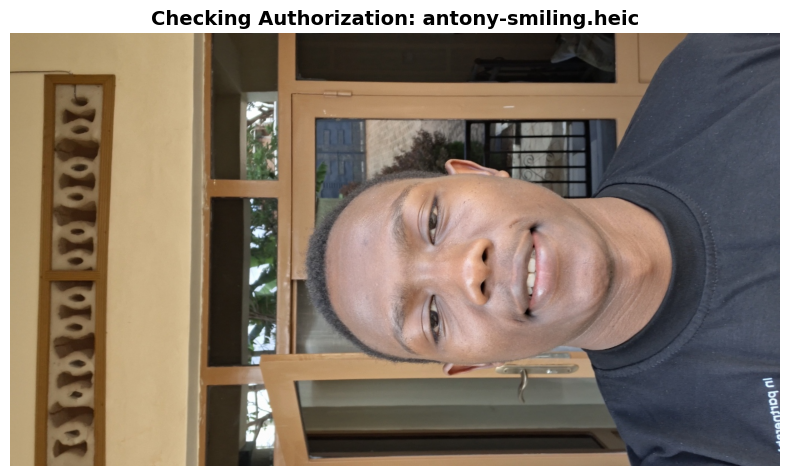

✓ Image displayed: (1386, 780)

CHECKING AUTHORIZATION
Image: antony-smiling.heic
Authorized members: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Confidence threshold: 30.00%

✓ AUTHORIZED: 1 (confidence: 85.50%)

Prediction Details:
  Predicted Member: 1
  Final Result: 1
  Confidence: 85.50%
  Is Authorized: ✓ YES
  Is Unknown: ✗ NO

Top 5 Predictions:
  → 1: 85.50%
    2: 5.25%
    3: 4.83%
    0: 4.42%

PREDICTION RESULTS

✅ AUTHORIZED
   Member: 1
   Confidence: 85.5%
   Status: Access GRANTED

----------------------------------------------------------------------
DETAILED BREAKDOWN
----------------------------------------------------------------------
Predicted Member: 1
Confidence Score: 85.50%
Is Authorized: True
Is Unknown Face: False

Top 3 Predictions:
  → 1: 85.50%
    2: 5.25%
    3: 4.83%

SUMMARY
✓ Model is working correctly!
✓ Successfully identified: 1
✓ Confidence level: 85.5%

✅ This person is AUTHORIZED to access the system.

-------------------------------

In [11]:
# ============================================================================
# TEST YOUR MODEL: Simple Authorization Check
# ============================================================================
# This cell lets you easily test if your trained model is working correctly
# Just set the image path and run!

import os

# ============================================================================
# STEP 1: Set your image path here
# ============================================================================
image_path = "/content/antony-smiling.heic"  # ← Change this to your image path

# ============================================================================
# STEP 2: Run the test (everything below runs automatically)
# ============================================================================

print("="*70)
print("TESTING MODEL: Authorization Check")
print("="*70)

# Check if image exists
if not image_path:
    print("⚠ Please set the 'image_path' variable above")
elif not os.path.exists(image_path):
    print(f"✗ Image not found at: {image_path}")
    print(f"\nPlease check the path. Common locations:")
    print(f"  - Google Drive: /content/drive/MyDrive/your_image.jpg")
    print(f"  - Images folder: /content/../images/your_image.jpg")
    print(f"  - Uploaded: /content/your_image.jpg")
else:
    print(f"✓ Image found: {os.path.basename(image_path)}")
    print(f"  Full path: {image_path}")

    # Check if model function is available
    if 'check_authorization' not in globals():
        print("\n✗ ERROR: check_authorization function not found!")
        print("  Please run Cell 13 first to load the prediction functions.")
    else:
        print("\n" + "-"*70)
        print("RUNNING PREDICTION...")
        print("-"*70)

        # Call the function
        result = check_authorization(image_path, display_image=True, verbose=True)

        # ====================================================================
        # DISPLAY RESULTS
        # ====================================================================
        print("\n" + "="*70)
        print("PREDICTION RESULTS")
        print("="*70)

        # Main result
        if result['is_authorized']:
            print(f"\n✅ AUTHORIZED")
            print(f"   Member: {result['predicted_member']}")
            print(f"   Confidence: {result['confidence']:.1%}")
            print(f"   Status: Access GRANTED")
        else:
            print(f"\n❌ UNAUTHORIZED")
            if result['is_unknown']:
                print(f"   Reason: Unknown face (not in training data)")
            else:
                print(f"   Reason: {result['message']}")
            print(f"   Confidence: {result['confidence']:.1%}")
            print(f"   Status: Access DENIED")

        # Detailed breakdown
        print("\n" + "-"*70)
        print("DETAILED BREAKDOWN")
        print("-"*70)
        print(f"Predicted Member: {result['predicted_member']}")
        print(f"Confidence Score: {result['confidence']:.2%}")
        print(f"Is Authorized: {result['is_authorized']}")
        print(f"Is Unknown Face: {result['is_unknown']}")

        # Show top predictions
        if result['all_predictions']:
            print(f"\nTop 3 Predictions:")
            for i, (member, prob) in enumerate(result['all_predictions'][:3], 1):
                marker = "→" if i == 1 else " "
                print(f"  {marker} {member}: {prob:.2%}")

        # Summary
        print("\n" + "="*70)
        print("SUMMARY")
        print("="*70)
        if result['is_authorized']:
            print(f"✓ Model is working correctly!")
            print(f"✓ Successfully identified: {result['predicted_member']}")
            print(f"✓ Confidence level: {result['confidence']:.1%}")
            print(f"\n✅ This person is AUTHORIZED to access the system.")
        else:
            print(f"✓ Model is working correctly!")
            print(f"✓ Detected unauthorized/unknown face")
            print(f"✓ Confidence level: {result['confidence']:.1%}")
            print(f"\n❌ This person is NOT AUTHORIZED to access the system.")

        print("\n" + "-"*70)
        print("To test another image, just change 'image_path' above and run again!")
        print("-"*70)
